# import pkg & get GPU


In [0]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers


import time
!pip install -q imageio
from IPython import display
tf.enable_eager_execution()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Num GPUs Available:  1


True

In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# load data

In [0]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip /content/drive/My\ Drive/Datasets/beauty_dataset_crop\ 2.zip

In [0]:
image_size = 64

# Resize and move to the same directory


In [0]:
import cv2
!mkdir /content/dataset
root = '/content/beauty_dataset_crop'
count = 0
for dir in os.listdir(root):
  path = root + '/' + dir
  if dir == '.DS_Store':
      continue
  for image in os.listdir(path):
    im_path = path+'/'+image
    img = cv2.imread(im_path)
    img= cv2.resize(img,(image_size,image_size))
    name = str(count) + '.jpg'
    cv2.imwrite('/content/dataset/'+name,img)
    count = count + 1

print(count)




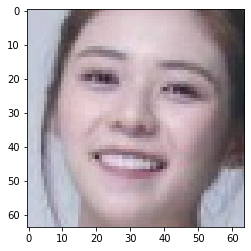

True

In [0]:
pp = '/content/dataset/108497.jpg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread(pp)
imgplot = plt.imshow(img)
plt.show()
img = cv2.imread(pp)
img = cv2.resize(img,(image_size,image_size))

cv2.imwrite('/content/test.jpg',img)
# for n in os.listdir('/content/dataset'):
#   print(n)

In [8]:
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dir_data      = "/content/dataset"
Ntrain        = 123100
nm_imgs       = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
img_shape     = (image_size, image_size, 3)

def get_npdata(nm_imgs_train):
  
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
      
        image = load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)/255.0
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))


Using TensorFlow backend.


X_train.shape = (123100, 64, 64, 3)


In [0]:
BUFFER_SIZE = 123120
BATCH_SIZE = 32



# Generator


In [0]:
def make_generator_model():
  
  model =tf.keras.models.Sequential()
  model.add(layers.InputLayer((1000,)))
  model.add( layers.Dense( 1024, use_bias=False,  input_shape=(1000,) )  )
  model.add( layers.Dense( 8*8*128, use_bias=False, activation="relu"  ) )
  model.add( layers.BatchNormalization( momentum=0.55 ) )
  model.add( layers.Reshape((8,8,128)))


  model.add( layers.Conv2DTranspose(1024, (5,5), strides=(2, 2), padding='same',use_bias=False ) )#16
  model.add( layers.BatchNormalization( momentum=0.55) )
  model.add( layers.LeakyReLU(0.2) )

  model.add( layers.Conv2DTranspose(512, (5,5), strides=(2, 2), padding='same', use_bias=False ) )#32
  model.add( layers.BatchNormalization( momentum=0.55 ) )
  model.add( layers.LeakyReLU(0.2) )
  model.add(layers.Dropout(0.2))

  model.add( layers.Conv2DTranspose(512, (5,5), strides=(2, 2), padding='same', use_bias=False ) )#32
  model.add( layers.BatchNormalization( momentum=0.55 ) )
  model.add( layers.LeakyReLU(0.2) )
  model.add(layers.Dropout(0.2))


  model.add( layers.Conv2DTranspose(256, (5,5), strides=(1, 1), padding='same', use_bias=False ) )# 64
  model.add( layers.BatchNormalization( momentum=0.51 ) )
  model.add( layers.LeakyReLU(0.2) )
  model.add(layers.Dropout(0.3))





  model.add( layers.Conv2DTranspose(3, (2,2), strides=(1, 1), padding='same', use_bias=False,  activation='tanh') )



  return model

# Test generator

In [11]:

generator = make_generator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.00007,0.5),
generator.compile(loss='binary_crossentropy', optimizer =tf.keras.optimizers.Adam(0.00007,0.5))
generator.summary()
# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)
# print(generated_image.numpy())

# plt.imshow(generated_image[0, :, :, :].numpy())
# print(generated_image[0, :, :, :].numpy().shape)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              1024000   
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              8388608   
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 1024)      3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 1024)      0

 x# New Section

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


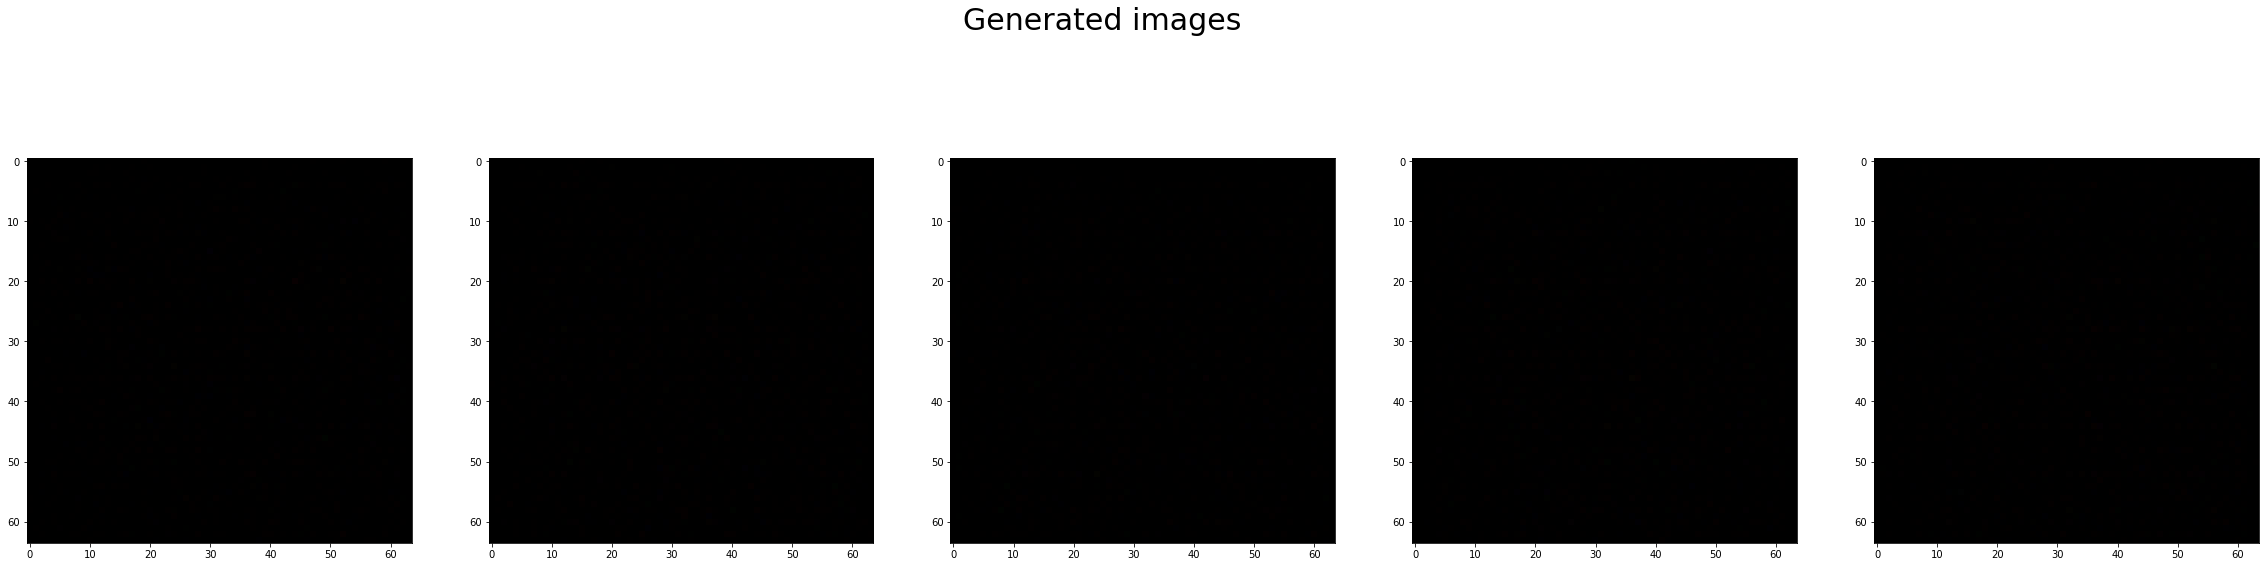

In [12]:
def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,5,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()
noise = np.random.normal(0,1,(5,1000))
# print(noise[0],'wwww',noise[1])
plot_generated_images(noise)


In [0]:
def make_discriminator_model():
  
  model = tf.keras.Sequential()


  model.add( layers.Conv2D(32, (5,5), activation='relu', padding='same', input_shape= [image_size,image_size,3]  ) )
  model.add( layers.MaxPooling2D((2, 2), strides=(2,2)) )
  # model.add( layers.LeakyReLU(alpha=0.28) )  
  model.add(layers.Dropout(0.3))

  model.add( layers.Conv2D( 64, (5,5),  activation='relu', padding='same'  ) )
  model.add( layers.Conv2D( 128, (5,5),  activation='relu', padding='same' ) )
  # model.add( layers.MaxPooling2D((2, 2), strides=(2,2) ))


  model.add( layers.Conv2D( 256, (5,5), activation='relu', padding='same'  ) )
  model.add( layers.Conv2D( 512, (3,3), activation='relu', padding='same' ) )
  model.add(layers.Dropout(0.3))

  model.add( layers.MaxPooling2D((2, 2), strides=(1,1)) )
  model.add(layers.Flatten())
  model.add(layers.Dense(1,activation='sigmoid'))


  # model.add( layers.LeakyReLU(alpha=0.28) )  
  # model.add(layers.Dropout(0.3))

  # model.add( layers.Conv2D( 256, (3,3), strides = (2,2), padding = 'same' ) )
  # model.add( layers.LeakyReLU(alpha=0.28) )  
  # model.add(layers.Dropout(0.3)) 

  # model.add( layers.Conv2D( 512, (3,3), strides = (2,2), padding = 'same' ) )
  # model.add( layers.LeakyReLU(alpha=0.28) )  
  # model.add(layers.Dropout(0.3))

  # model.add(layers.Flatten())
  # model.add(layers.Dense(1))

  return model



# Test Discriminater

In [14]:
discriminator = make_discriminator_model()
discriminator_optimizer = tf.keras.optimizers.Adam(0.00007,0.5)
discriminator.compile(loss= 'binary_crossentropy', optimizer = discriminator_optimizer,metrics   = ['accuracy'])
# img = generator(noise)
# predict = discriminator(img)
# print(predict)
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       819456    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 512)      

# GAN

In [0]:
def build_gan(g,d):
    model = tf.keras.Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

In [16]:
gan = build_gan(generator,discriminator)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4))
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 3)         35672064  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 2750273   
Total params: 38,422,337
Trainable params: 35,651,072
Non-trainable params: 2,771,265
_________________________________________________________________


In [0]:

# discriminator.save_weights('dtmp.h5')
# generator.save_weights('gtmp.h5')

# Train 


In [0]:
def train(G, D,GAN,epochs,batch_size, start,des_dir ='/content/drive/My Drive/beauty_generator/model_history'):
    generator = G
    discriminator = D
    gan = GAN
    history = list()
    for epoch in range(epochs):
        Dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder = True)
        batch_count = 0
        d_loss = (0,0)
        g_loss = (0,0)
        d_not_train = 0
        noise =  np.random.normal(0,1,(batch_size,1000))
        for batch in Dataset:
            # D train
            discriminator.trainable = True
            fake_images = generator.predict(noise)
            d_loss_real = discriminator.train_on_batch(batch, np.ones( (batch_size,1) ))
            d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size,1)))
            d_loss = 0.5*np.add(d_loss_real , d_loss_fake)
            # G train
            discriminator.trainable = False
            generator.trainable = True
            noise =  np.random.normal(0,1,(batch_size,1000))
            valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)
            g_loss_batch = gan.train_on_batch(noise,valid_y)
            g_loss = np.add(g_loss , g_loss_batch)            
            discriminator.trainable = True

            # print result
            batch_count = batch_count + 1
            if (batch_count % 100) == 0:
                fig = plt.figure(figsize=(30,10))
                img = generator.predict(noise)
                nplot = 4
                for count in range(1,nplot):
                    ax = fig.add_subplot(1,nplot,count)
                    ax.imshow(img[count])
                plt.savefig(str(epoch)+'_'+str(batch_count)+'.png')
                plt.show()
            # save model
            if (batch_count % 1000) == 0: 
                generator.save(des_dir+'/generator＿'+str(start+epoch)+'_'+str(batch_count)+'.h5',include_optimizer = True) 
                discriminator.save(des_dir+'/discriminator＿'+str(start +epoch)+'_'+str(batch_count)+'.h5',include_optimizer = True) 
                history.append(d_loss)
            if (batch_count % 10) == 0: 
                print('batch: {}, d_loss: {}'.format(batch_count, d_loss ), d_not_train)

            # Epoch end

        
        # d_loss = d_loss/batch_count
        # history.append((epoch,d_loss,g_loss))
        print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch,d_loss,g_loss))
        # generator.save(des_dir+'/generator＿'+str(start+epoch)+'.h5',include_optimizer = False) 
        # discriminator.save(des_dir+'/discriminator＿'+str(start +epoch)+'.h5',include_optimizer = False) 

    return history



batch: 1440, d_loss: [0.26129818 0.90625   ] 0
batch: 1450, d_loss: [0.25941965 0.890625  ] 0
batch: 1460, d_loss: [0.2874565 0.859375 ] 0
batch: 1470, d_loss: [0.25544912 0.859375  ] 0
batch: 1480, d_loss: [0.2119298 0.90625  ] 0
batch: 1490, d_loss: [0.22160119 0.921875  ] 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


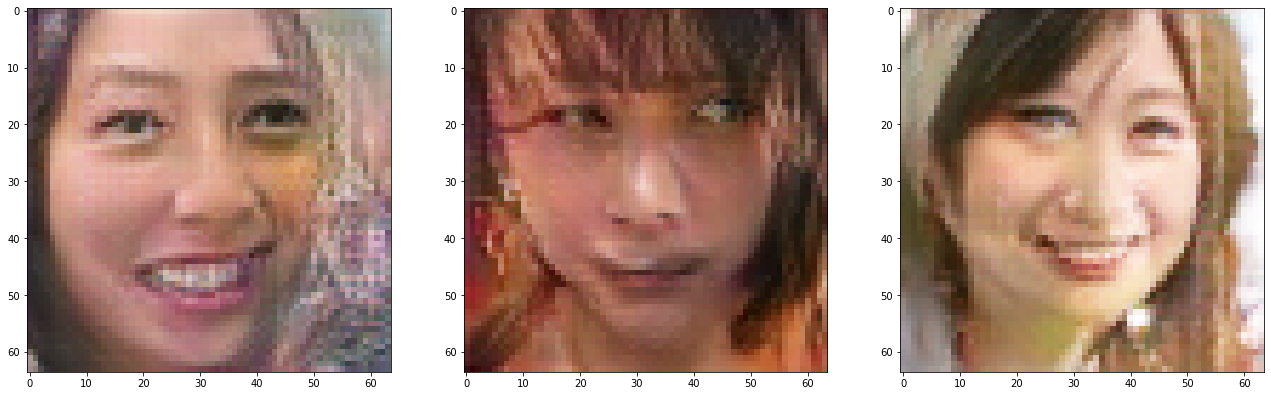

batch: 1500, d_loss: [0.12106986 0.96875   ] 0
batch: 1510, d_loss: [0.44538322 0.828125  ] 0
batch: 1520, d_loss: [0.12690185 0.9375    ] 0
batch: 1530, d_loss: [0.2333343 0.90625  ] 0
batch: 1540, d_loss: [0.1976258 0.953125 ] 0
batch: 1550, d_loss: [0.18470222 0.890625  ] 0
batch: 1560, d_loss: [0.29195306 0.890625  ] 0
batch: 1570, d_loss: [0.32277602 0.859375  ] 0
batch: 1580, d_loss: [0.28491288 0.859375  ] 0
batch: 1590, d_loss: [0.1377593 0.96875  ] 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


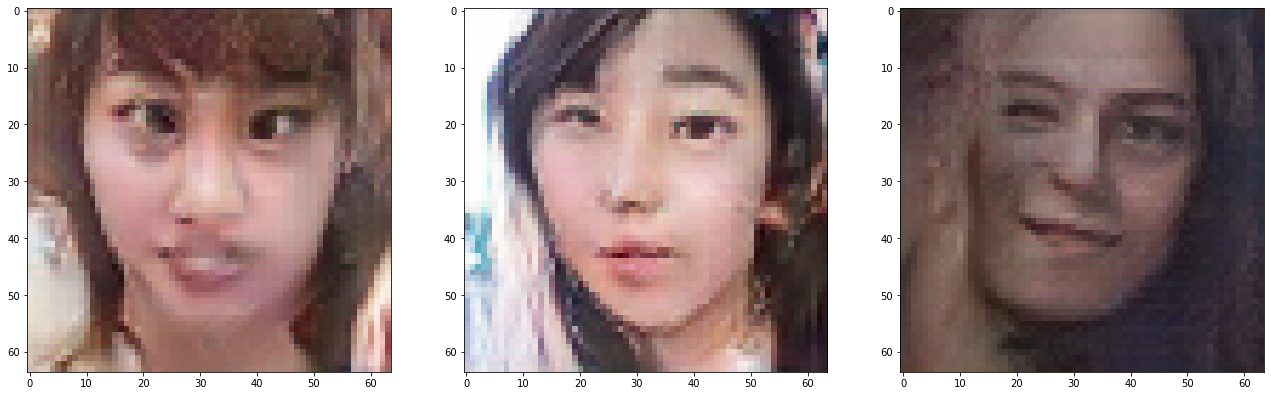

batch: 1600, d_loss: [0.17947449 0.9375    ] 0
batch: 1610, d_loss: [0.16245162 0.953125  ] 0
batch: 1620, d_loss: [0.5588012 0.6875   ] 0
batch: 1630, d_loss: [0.19535533 0.90625   ] 0
batch: 1640, d_loss: [0.24882025 0.90625   ] 0
batch: 1650, d_loss: [0.29654467 0.90625   ] 0
batch: 1660, d_loss: [0.21713574 0.9375    ] 0
batch: 1670, d_loss: [0.30298653 0.859375  ] 0
batch: 1680, d_loss: [0.16326442 0.953125  ] 0
batch: 1690, d_loss: [0.2335508 0.890625 ] 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


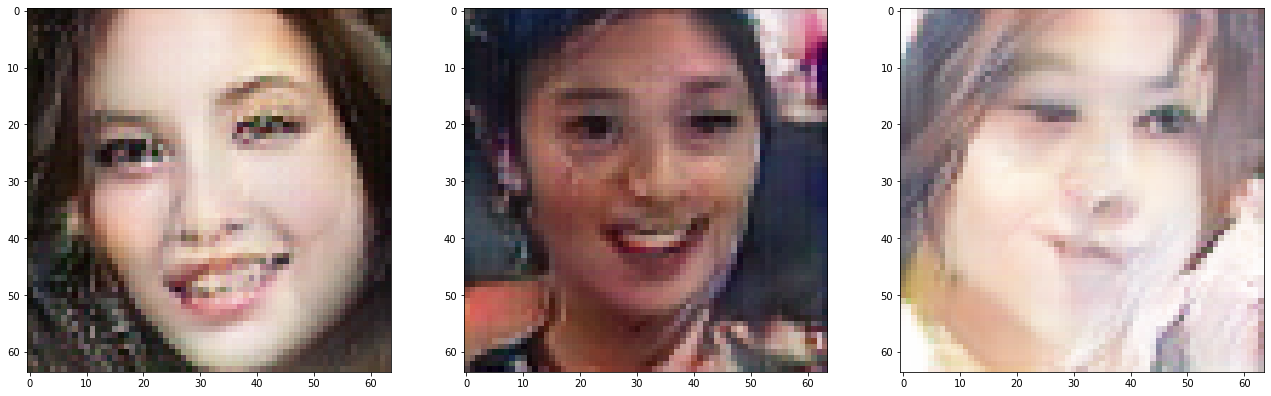

batch: 1700, d_loss: [0.19471303 0.921875  ] 0
batch: 1710, d_loss: [0.33505094 0.890625  ] 0
batch: 1720, d_loss: [0.28495565 0.875     ] 0
batch: 1730, d_loss: [0.20763609 0.90625   ] 0
batch: 1740, d_loss: [0.37389565 0.859375  ] 0
batch: 1750, d_loss: [0.28275082 0.859375  ] 0
batch: 1760, d_loss: [0.22329296 0.953125  ] 0
batch: 1770, d_loss: [0.26512805 0.875     ] 0
batch: 1780, d_loss: [0.11806923 0.96875   ] 0
batch: 1790, d_loss: [0.23444796 0.90625   ] 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


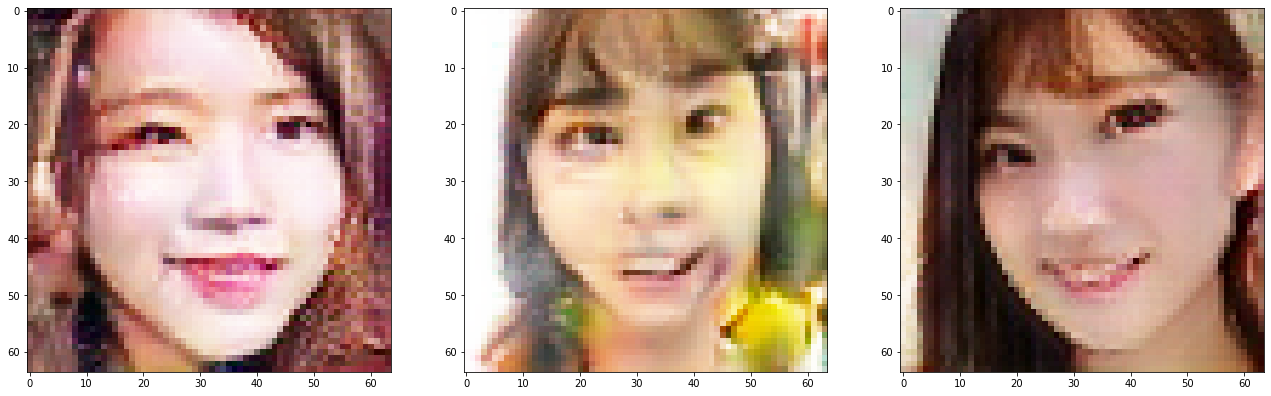

batch: 1800, d_loss: [0.21522108 0.90625   ] 0
batch: 1810, d_loss: [0.24757914 0.921875  ] 0
batch: 1820, d_loss: [0.18371052 0.921875  ] 0
batch: 1830, d_loss: [0.5384239 0.75     ] 0
batch: 1840, d_loss: [0.15663566 0.921875  ] 0
batch: 1850, d_loss: [0.2679331 0.875    ] 0
batch: 1860, d_loss: [0.24048428 0.890625  ] 0
batch: 1870, d_loss: [0.26411483 0.90625   ] 0
batch: 1880, d_loss: [0.31726706 0.859375  ] 0
batch: 1890, d_loss: [0.23362327 0.90625   ] 0


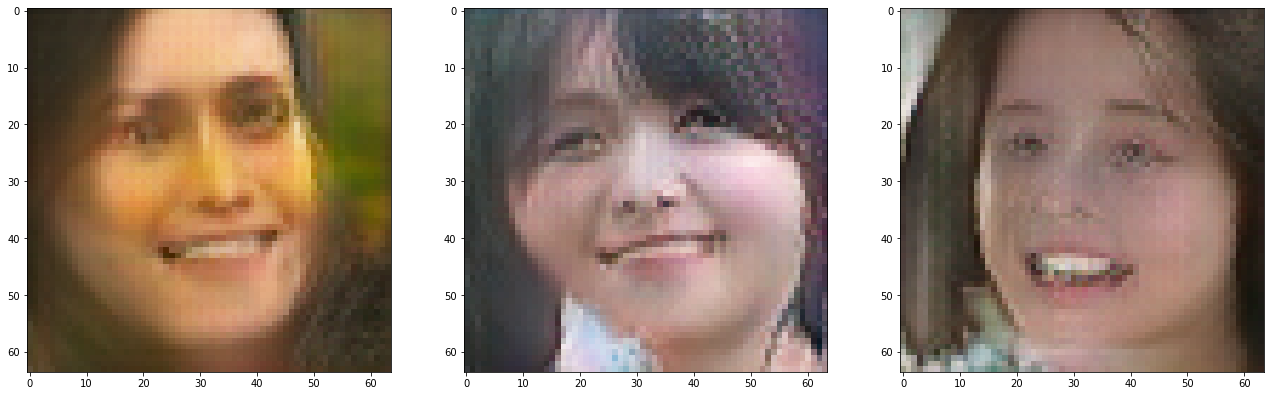

batch: 1900, d_loss: [0.40274072 0.8125    ] 0
batch: 1910, d_loss: [0.43177557 0.84375   ] 0
batch: 1920, d_loss: [0.22716895 0.921875  ] 0
batch: 1930, d_loss: [0.19379613 0.90625   ] 0
batch: 1940, d_loss: [0.37018895 0.78125   ] 0
batch: 1950, d_loss: [0.32894462 0.890625  ] 0
batch: 1960, d_loss: [0.15168868 0.96875   ] 0
batch: 1970, d_loss: [0.3681385 0.875    ] 0
batch: 1980, d_loss: [0.32822567 0.859375  ] 0
batch: 1990, d_loss: [0.28461653 0.859375  ] 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


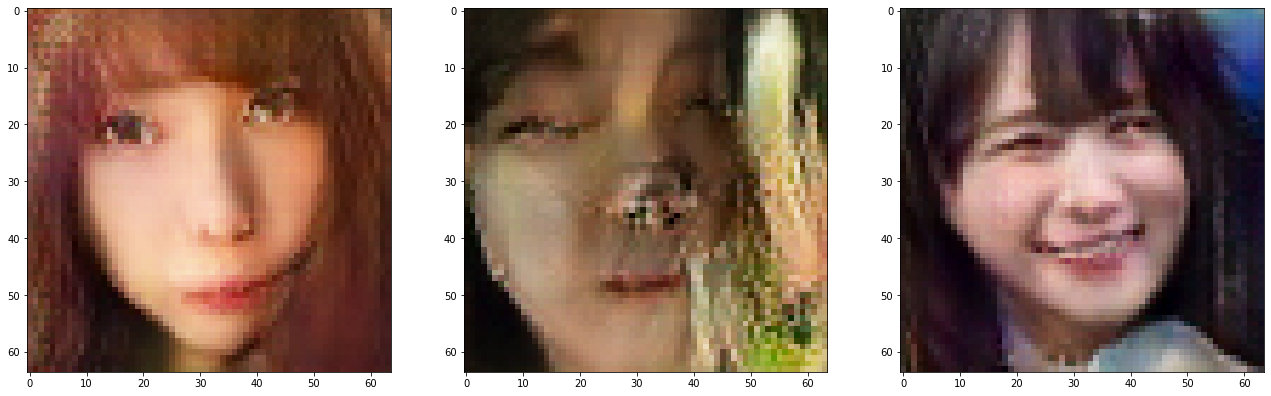

batch: 2000, d_loss: [0.20989205 0.9375    ] 0
batch: 2010, d_loss: [0.12242594 0.96875   ] 0
batch: 2020, d_loss: [0.26721314 0.90625   ] 0
batch: 2030, d_loss: [0.1697777 0.9375   ] 0
batch: 2040, d_loss: [0.18549675 0.921875  ] 0
batch: 2050, d_loss: [0.38330498 0.828125  ] 0
batch: 2060, d_loss: [0.3199089 0.875    ] 0
batch: 2070, d_loss: [0.2693345 0.890625 ] 0
batch: 2080, d_loss: [0.21121258 0.90625   ] 0
batch: 2090, d_loss: [0.2042861 0.890625 ] 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


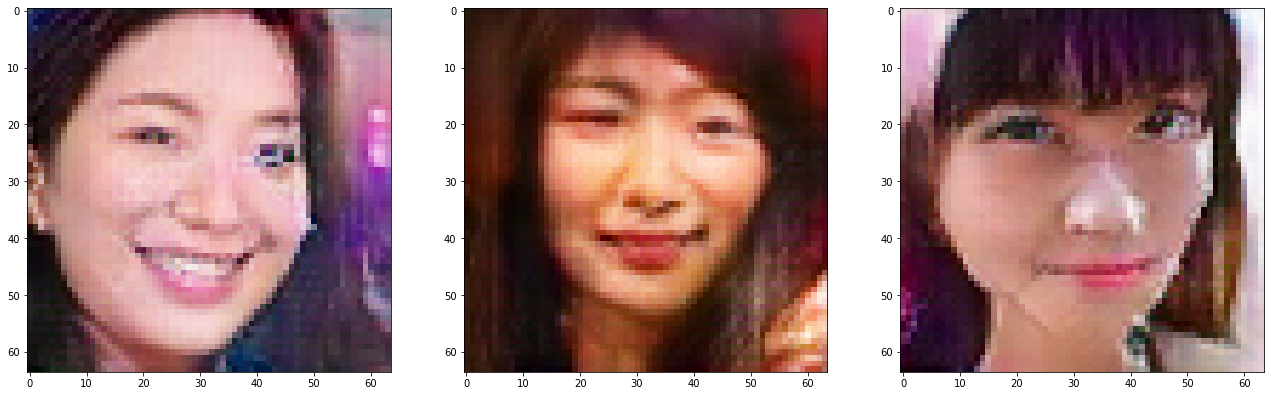

batch: 2100, d_loss: [0.13955384 0.953125  ] 0
batch: 2110, d_loss: [0.28264356 0.859375  ] 0
batch: 2120, d_loss: [0.40863913 0.84375   ] 0
batch: 2130, d_loss: [0.29473105 0.859375  ] 0
batch: 2140, d_loss: [0.19720495 0.890625  ] 0
batch: 2150, d_loss: [0.27606145 0.859375  ] 0
batch: 2160, d_loss: [0.21647291 0.90625   ] 0
batch: 2170, d_loss: [0.23044746 0.90625   ] 0
batch: 2180, d_loss: [0.18784562 0.921875  ] 0
batch: 2190, d_loss: [0.2475706 0.90625  ] 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


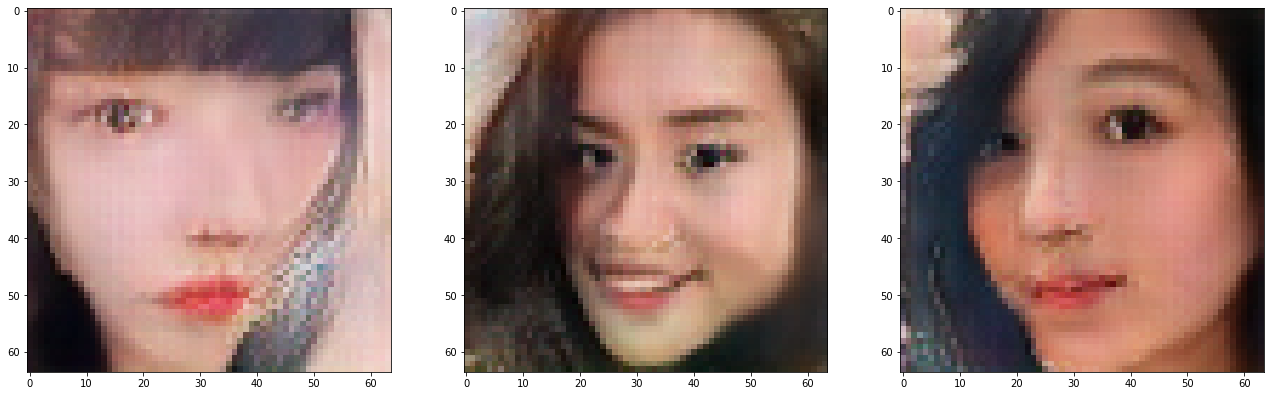

batch: 2200, d_loss: [0.24563868 0.90625   ] 0
batch: 2210, d_loss: [0.20417339 0.9375    ] 0
batch: 2220, d_loss: [0.3132937 0.859375 ] 0
batch: 2230, d_loss: [0.21721482 0.890625  ] 0
batch: 2240, d_loss: [0.30108213 0.859375  ] 0
batch: 2250, d_loss: [0.27175182 0.875     ] 0
batch: 2260, d_loss: [0.14076084 0.953125  ] 0
batch: 2270, d_loss: [0.21989328 0.921875  ] 0
batch: 2280, d_loss: [0.14570539 0.953125  ] 0
batch: 2290, d_loss: [0.2835524 0.875    ] 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


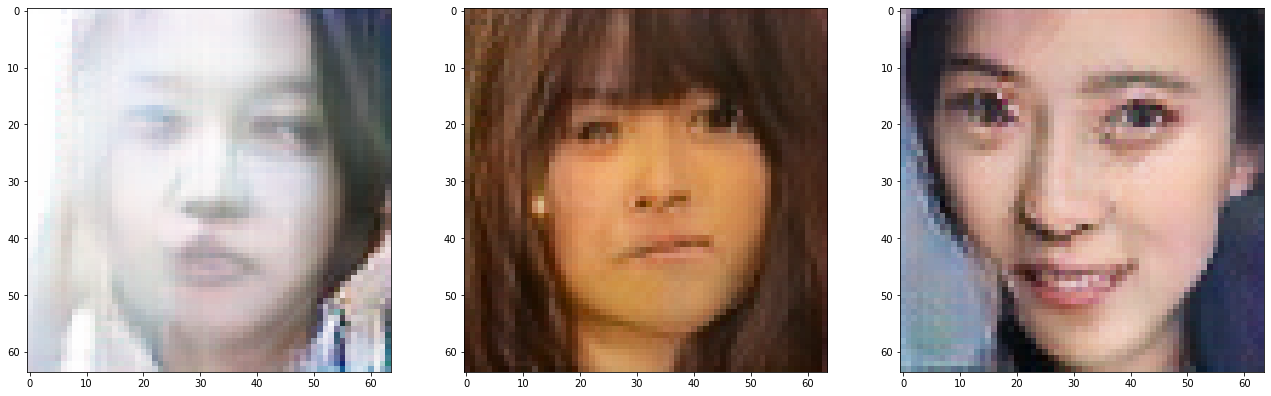

batch: 2300, d_loss: [0.19615541 0.90625   ] 0
batch: 2310, d_loss: [0.2551638 0.859375 ] 0
batch: 2320, d_loss: [0.1688895 0.9375   ] 0
batch: 2330, d_loss: [0.24043083 0.875     ] 0
batch: 2340, d_loss: [0.16695678 0.953125  ] 0
batch: 2350, d_loss: [0.31998557 0.8125    ] 0
batch: 2360, d_loss: [0.18727262 0.921875  ] 0
batch: 2370, d_loss: [0.26153272 0.875     ] 0
batch: 2380, d_loss: [0.24234378 0.921875  ] 0
batch: 2390, d_loss: [0.22079778 0.859375  ] 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


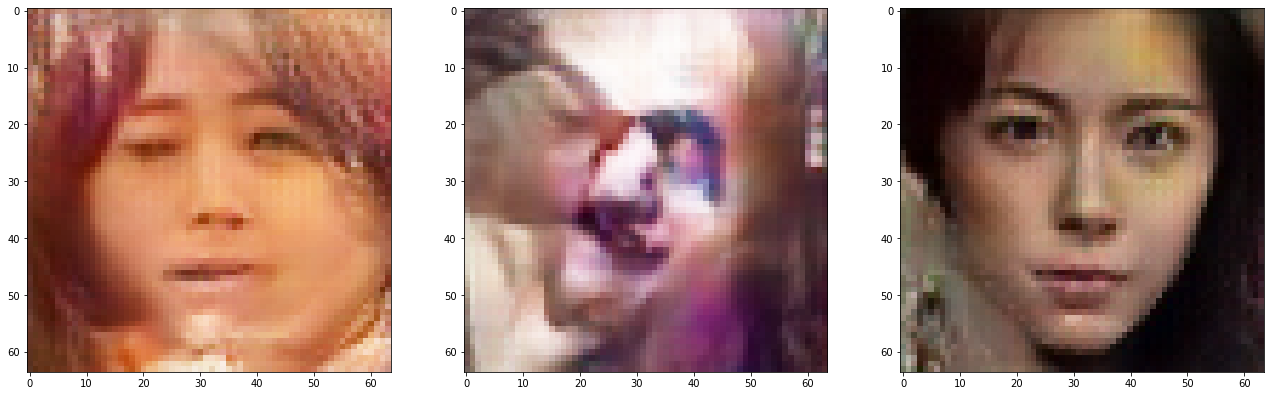

batch: 2400, d_loss: [0.15819257 0.9375    ] 0
batch: 2410, d_loss: [0.17802998 0.921875  ] 0
batch: 2420, d_loss: [0.21540816 0.9375    ] 0
batch: 2430, d_loss: [0.17691469 0.953125  ] 0


In [0]:
history = train(generator, discriminator, gan, 50, BATCH_SIZE,0)

# Test result

In [0]:
# generator = tf.keras.models.load_model('/content/model_history/generator＿4.h5')
# discriminator = tf.keras.models.load_model('/content/model_history/discriminator＿4.h5')
plot_generated_images(noise)


# LOAD MODEL

In [0]:
# generator = tf.keras.models.load_model('/content/model_history/generator＿5_100.h5')
# discriminator = tf.keras.models.load_model('/content/model_history/discriminator＿5_100.h5')
